# TOPIC MODELING

Topic Modelling is the task of using unsupervised learning to extract the main topics (represented as a set of words) that occur in a collection of documents.

## Working Problem

Today, I will be showing how to use regular LDA and guidedLDA for topic modeling and I tested the LDA algorithm on 20 Newsgroup data present in sklearn set which has thousands of news articles from many sections of a news report

## Latent Dirichlet Allocation ##

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. 
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. 

## Step 1: Load the dataset

The dataset we'll use is the 20newsgroup dataset that is available from sklearn. This dataset has news articles grouped into 20 news categories

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

In [2]:
print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(11314,) (11314,)


In [3]:
# Lets look at some sample news and target groups
print(newsgroups_train.data[:1],newsgroups_train.target[:1]) 

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"] [7]


In [4]:
print(list(newsgroups_train.target_names)), 

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


#### As you can see that there are some distinct themes in the news categories like 

* sports 
* religion
* science 
* technology
* politics etc.

## Step 2: Simple Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.


In [5]:
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/knolly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Let's Lemmatize
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [7]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense
print(WordNetLemmatizer().lemmatize('going', pos = 'v')) # present tense to present tense
print(WordNetLemmatizer().lemmatize('gone', pos = 'v')) # past tense to present tense
print(WordNetLemmatizer().lemmatize('goes', pos = 'v')) # present tense to present tense
print(WordNetLemmatizer().lemmatize('go', pos = 'v')) # present tense to present tense

go
go
go
go
go


In [8]:
print(WordNetLemmatizer().lemmatize('played', pos = 'v'))
print(WordNetLemmatizer().lemmatize('playing', pos = 'v'))
print(WordNetLemmatizer().lemmatize('play', pos = 'v'))

play
play
play


### Stemming the Stemmer
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [9]:
import pandas as pd
stemmer = SnowballStemmer("english")
original_words = ["Today", "I", "will", "be", "giving", "a", "talk", "in", "the", "fifth", "elephant", "2019", "conference"]
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,Today,today
1,I,i
2,will,will
3,be,be
4,giving,give
5,a,a
6,talk,talk
7,in,in
8,the,the
9,fifth,fifth


In [10]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def stemming_and_lemmatizing(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(stemming_and_lemmatizing(token))
            
    return result

In [11]:
'''
Preview a document after preprocessing
'''
document_num = 50
doc_sample = 'This disk has failed many times. I would like to get it replaced.'

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocessing(doc_sample))

Original document: 
['This', 'disk', 'has', 'failed', 'many', 'times.', 'I', 'would', 'like', 'to', 'get', 'it', 'replaced.']


Tokenized and lemmatized document: 
['disk', 'fail', 'time', 'like', 'replac']


Let's now preprocess all the news headlines we have. To do that, we iterate over the list of documents in our training sample

In [12]:
docs = []

for doc in newsgroups_train.data:
    docs.append(preprocessing(doc))

In [13]:
'''
Preview 'docs' to see what all words are being captured
'''
print(docs[:2])

[['lerxst', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'bricklin', 'door', 'small', 'addit', 'bumper', 'separ', 'rest', 'bodi', 'know', 'tellm', 'model', 'engin', 'spec', 'year', 'product', 'histori', 'info', 'funki', 'look', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['guykuo', 'carson', 'washington', 'subject', 'clock', 'poll', 'final', 'summari', 'final', 'clock', 'report', 'keyword', 'acceler', 'clock', 'upgrad', 'articl', 'shelley', 'qvfo', 'innc', 'organ', 'univers', 'washington', 'line', 'nntp', 'post', 'host', 'carson', 'washington', 'fair', 'number', 'brave', 'soul', 'upgrad', 'clock', 'oscil', 'share', 'experi', 'poll', 'send', 'brief', 'messag', 'detail', 'experi', 'procedur', 'speed', 'attain', 'rat', 'speed', 'card', 'adapt', 'heat', 'sink', 'hour', 'usag', 'floppi', 'disk', 'function', 'floppi', 'especi', 'request', 'summar', 'day',

## Step 3: Bag of words on the dataset

In [14]:
'''
capturing all the different words present in 'docs'
'''
all_word_corpus = []
for doc in docs:
    all_word_corpus += doc

** Length of docs vs. Various Percentiles **

Filter out docs that have

* less than a certain size (absolute number) or
* more than a certain size (fraction of total corpus size, not absolute number).

In [15]:
doc_lengths = pd.Series([len(sent) for sent in docs])

In [16]:
doc_lengths.describe(percentiles=[x/10 for x in range(11)])

count    11314.000000
mean       126.780272
std        234.656018
min          9.000000
0%           9.000000
10%         37.000000
20%         48.000000
30%         58.000000
40%         69.000000
50%         81.000000
60%         94.000000
70%        114.000000
80%        144.000000
90%        213.000000
100%      5494.000000
max       5494.000000
dtype: float64

In [17]:
# printing 0% to 10% percentiles
doc_lengths.describe(percentiles=[x/100 for x in range(0,10)])

count    11314.000000
mean       126.780272
std        234.656018
min          9.000000
0%           9.000000
1%          20.000000
2%          23.000000
3%          27.000000
4%          28.000000
5%          30.000000
6%          32.000000
7.0%        33.000000
8%          34.000000
9%          36.000000
50%         81.000000
max       5494.000000
dtype: float64

In [18]:
# printing 90% to 100% percentiles
doc_lengths.describe(percentiles=[x/100 for x in range(90,100)])

count    11314.000000
mean       126.780272
std        234.656018
min          9.000000
50%         81.000000
90%        213.000000
91%        224.000000
92%        241.000000
93%        262.090000
94%        288.000000
95%        319.000000
96%        367.000000
97%        426.610000
98%        558.220000
99%        885.000000
max       5494.000000
dtype: float64

In [19]:
# chosing upper_bound = 300 and lower_bound = 30
chosen_docs = []
for doc in docs:
    if len(doc) > 30 and len(doc) < 300:
        chosen_docs.append(doc)

In [20]:
print(len(docs), len(chosen_docs))

11314 10063


In [ ]:
docs = chosen_docs

In [38]:
'''
capturing all the different words present in 'docs'
'''
all_word_corpus = []
for doc in docs:
    all_word_corpus += doc

In [58]:
word_frequency_dict = Counter(all_word_corpus)

## Step 4: Creating Corpus Before LDA ##

Some of the initialisations necessary for LDA are:
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **word2id** is a mapping from words (strings) to word ids (integers). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **vocab** is a list of words (strings). It is used to determine the various words used in the text, as well as for debugging and topic printing.

In [30]:
word2id = {}
id2word = {}
vocab = []
currentWordId = 0

In [31]:
from collections import Counter

for word, count in Counter(all_word_corpus).most_common():
    word2id[word] = currentWordId
    id2word[currentWordId] = word
    currentWordId += 1
    vocab.append(word)

In [32]:
len(docs), len(word2id), len(id2word)

(10063, 42185, 42185)

In [40]:
final_docs = []

for doc in docs:
    currentDoc = []
    for word in doc: 
        if word in word2id:
            currentDoc.append(word2id[word])
    final_docs.append(currentDoc)

In [41]:
docs = final_docs

## Step 5: Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

Only parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.

In [45]:
X = np.zeros((len(docs), len(word2id)),dtype=int)

In [46]:
X.shape

(10063, 42185)

In [47]:
for idx, doc in enumerate(docs):
    for idy in doc:
        X[idx,idy] += 1

### Case 1 : Regular LDA ###

In [53]:
# pip install guidedlda
from guidedlda import GuidedLDA as lda

In [119]:
model = lda(n_topics= 10, n_iter=1000, random_state=1, refresh=50)
model.fit(X)

topic_word = model.topic_word_
n_top_words = 25
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    print("\n")
    print('Topic {} : {}'.format(i, ', '.join(topic_words)))

INFO:guidedlda:n_documents: 10063
INFO:guidedlda:vocab_size: 42185
INFO:guidedlda:n_words: 959742
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -10866709
INFO:guidedlda:<50> log likelihood: -8360201
INFO:guidedlda:<100> log likelihood: -8252964
INFO:guidedlda:<150> log likelihood: -8201943
INFO:guidedlda:<200> log likelihood: -8172805
INFO:guidedlda:<250> log likelihood: -8144340
INFO:guidedlda:<300> log likelihood: -8125297
INFO:guidedlda:<350> log likelihood: -8113552
INFO:guidedlda:<400> log likelihood: -8106531
INFO:guidedlda:<450> log likelihood: -8101962
INFO:guidedlda:<500> log likelihood: -8098727
INFO:guidedlda:<550> log likelihood: -8095234
INFO:guidedlda:<600> log likelihood: -8092530
INFO:guidedlda:<650> log likelihood: -8090496
INFO:guidedlda:<700> log likelihood: -8088842
INFO:guidedlda:<750> log likelihood: -8088769
INFO:guidedlda:<800> log likelihood: -8088353
INFO:guidedlda:<850> log likelihood: -8089444
INFO:guidedlda:<900> 

/n
Topic 0 : write, christian, subject, line, peopl, organ, articl, know, think, believ, say, jesus, univers, israel, like, come, isra, post, time, jew, question, bibl, world, church, want
/n
Topic 1 : line, organ, subject, write, articl, post, space, nasa, govern, chip, encrypt, like, clipper, know, nntp, host, peopl, access, secur, state, think, year, work, distribut, univers
/n
Topic 2 : subject, line, organ, write, articl, pitt, know, bank, post, food, scienc, gordon, univers, think, like, repli, doctor, caus, time, medic, host, diseas, effect, problem, work
/n
Topic 3 : line, window, subject, organ, post, write, file, host, nntp, program, univers, know, thank, graphic, help, like, problem, need, articl, look, display, mail, repli, applic, work
/n
Topic 4 : line, subject, organ, drive, post, card, write, window, univers, problem, host, nntp, know, work, articl, disk, scsi, like, thank, driver, file, need, mail, softwar, appl
/n
Topic 5 : write, peopl, subject, line, organ, articl, 

In [112]:
top_words = list(reversed(model.word_topic_.T[1].argsort()))

In [113]:
for word in top_words[0:300]:
    print(vocab[word], word_frequency_dict[vocab[word]])

escrow 283
cramer 217
alaska 212
optilink 205
crypto 197
wiretap 194
amanda 113
gtoal 110
nist 109
higgin 106
nsmca 93
baalk 93
cryptographi 92
spacecraft 85
zoolog 82
sternlight 76
mccall 76
qualcomm 75
steveh 72
ncsl 70
decrypt 69
pyron 67
den 64
hendrick 61
consent 61
rwing 59
dtmedin 58
catbyt 58
shearson 57
strnlght 57
nrhj 55
toal 55
crypt 51
skndiv 51
mksol 51
proton 51
shafer 49
fnalf 49
centaur 49
observatori 48
wwiz 46
tempest 45
utzoo 45
pmetzger 44
cipher 43
sysmgr 43
aerospac 42
encrypt 641
billboard 40
ncratl 40
templeton 39
csrc 37
dorothi 37
kadi 37
petaluma 36
gehrel 36
fairbank 36
tuinstra 35
desi 35
dillon 34
metzger 34
gizw 34
dietz 34
ipser 34
bellovin 33
ncsc 33
topaz 33
nicho 33
myrto 33
borden 32
mancus 32
theporch 32
medin 31
caronni 31
scharfi 31
bhjn 31
mizzou 31
ssto 31
cac 31
pmfq 30
amolitor 30
rscharfi 30
enzo 30
regim 29
hennessi 29
cryptograph 29
pork 28
geod 28
msfc 28
jarthur 27
tcmay 27
cryptosystem 27
fraer 27
snark 27
sherzer 27
lick 26
eavesdrop 2

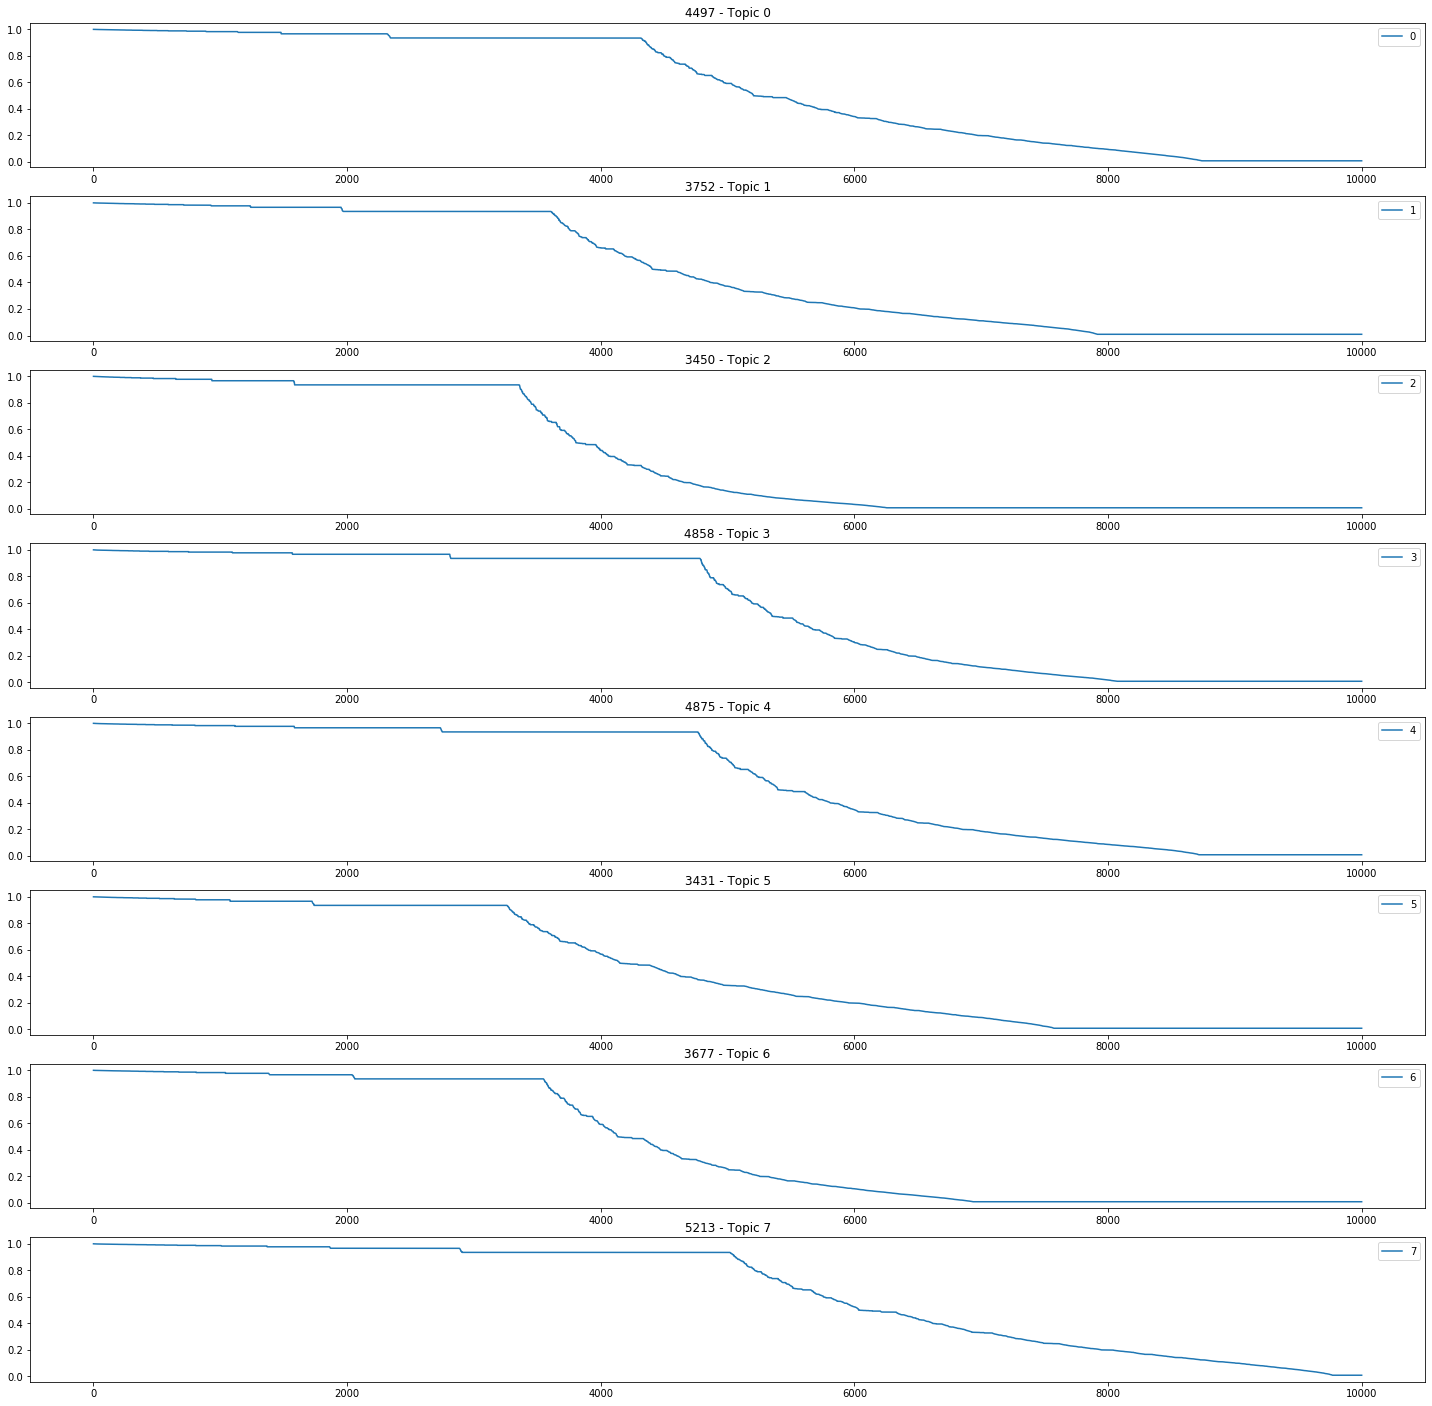

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
n_topics = 8

f, axs = plt.subplots(n_topics, figsize=(25,25))
for topic_id, topic_dist in enumerate(model.word_topic_.T):
    topic_score = sorted(topic_dist, reverse=True)
    count_score = len(list(filter(lambda val: val > 0.8, topic_score)))
    ax = axs[topic_id]
    ax.plot(topic_score[0:10000])
    ax.set_title(str(count_score) + ' - ' + f'Topic {topic_id}')
    ax.legend([str(topic_id)], loc='upper right')
#str(len(set(topic_id_to_coverage[topic_id]))))

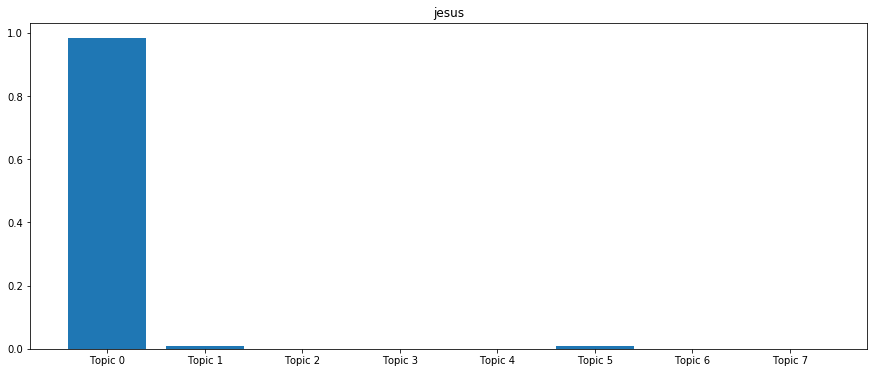

In [118]:
for key, value in word2id.items():
    if key =='jesus':
        plt.bar([i for i in range(len(model.word_topic_[0]))],model.word_topic_[value])
        plt.rcParams["figure.figsize"] = [15,6]
        plt.xticks([i for i in range(len(model.word_topic_[0]))],[f'Topic {i}' for i in range(len(model.word_topic_[0]))])
        plt.title(key)

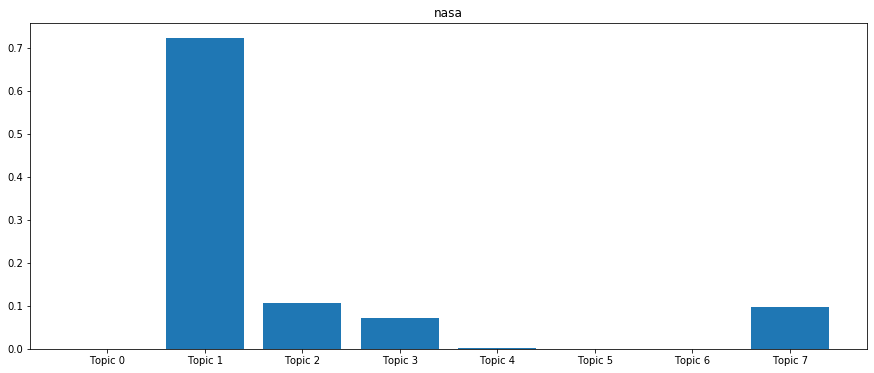

In [117]:
for key, value in word2id.items():
    if key =='nasa':
        plt.bar([i for i in range(len(model.word_topic_[0]))],model.word_topic_[value])
        plt.rcParams["figure.figsize"] = [15,6]
        plt.xticks([i for i in range(len(model.word_topic_[0]))],[f'Topic {i}' for i in range(len(model.word_topic_[0]))])
        plt.title(key)

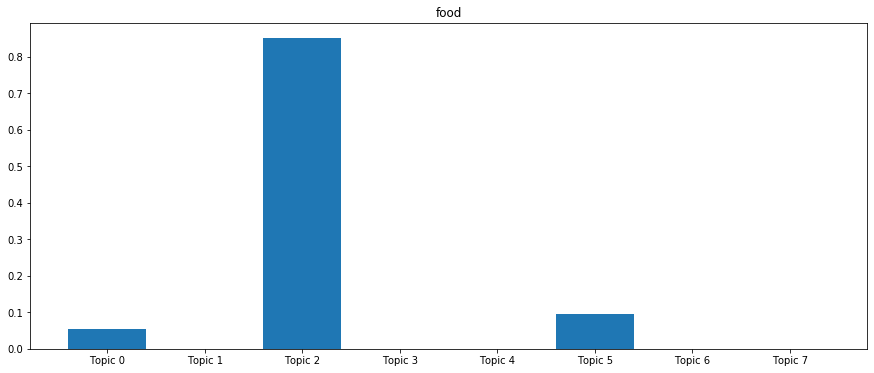

In [116]:
for key, value in word2id.items():
    if key =='food':
        plt.bar([i for i in range(len(model.word_topic_[0]))],model.word_topic_[value])
        plt.rcParams["figure.figsize"] = [15,6]
        plt.xticks([i for i in range(len(model.word_topic_[0]))],[f'Topic {i}' for i in range(len(model.word_topic_[0]))])
        plt.title(key)

### Classification of the topics ###

Using the words in each topic and their corresponding weights, what categories were you able to infer?

* 0: Graphics Cards
* 1: Religion
* 2: Space
* 3: Politics
* 4: Gun Violence
* 5: Technology
* 6: Sports
* 7: Encryption 

### Case 2 : Guided LDA ###

In [124]:
seed_dict = {'Graphics Cards' : 0, 'Space' : 1, 'Religion' : 2 , 'Politics' : 3, 'Gun Violence' : 4,
             'Technology' : 5, 'Sports' : 6, 'Encryption' : 7 }

In [125]:
seed_topics = {}

In [126]:
# Topic 0: Possibly Graphics Cards
seed_topics.update({
    word2id["drive"] : seed_dict["Graphics Cards"], word2id["sale"] : seed_dict["Graphics Cards"], 
    word2id["driver"] : seed_dict["Graphics Cards"], word2id["wire"] : seed_dict["Graphics Cards"], 
    word2id["card"] : seed_dict["Graphics Cards"], word2id["graphic"] : seed_dict["Graphics Cards"], 
    word2id["price"] : seed_dict["Graphics Cards"], word2id["appl"] : seed_dict["Graphics Cards"],
    word2id["softwar"] : seed_dict["Graphics Cards"], word2id["monitor"] : seed_dict["Graphics Cards"]
})

In [127]:
# Topic 2: Possibly Space
seed_topics.update({
    word2id["space"] : seed_dict["Space"], word2id["nasa"] : seed_dict["Space"], 
    word2id["drive"] : seed_dict["Space"], word2id["scsi"] : seed_dict["Space"], 
    word2id["orbit"] : seed_dict["Space"], word2id["launch"] : seed_dict["Space"],
    word2id["data"] : seed_dict["Space"], word2id["control"] : seed_dict["Space"], 
    word2id["earth"] : seed_dict["Space"],word2id["moon"] : seed_dict["Space"]
})

In [128]:
# Topic 6: Possibly Sports
seed_topics.update({
    word2id["game"] : seed_dict["Sports"], word2id["team"] : seed_dict["Sports"], 
    word2id["play"] : seed_dict["Sports"], word2id["player"] : seed_dict["Sports"], 
    word2id["hockey"] : seed_dict["Sports"], word2id["season"] : seed_dict["Sports"], 
    word2id["pitt"] : seed_dict["Sports"], word2id["score"] : seed_dict["Sports"], 
    word2id["leagu"] : seed_dict["Sports"], word2id["pittsburgh"] : seed_dict["Sports"]
})

In [129]:
# Topic 4: Possibly Politics
seed_topics.update({
    word2id["armenian"] : seed_dict["Politics"], word2id["public"] : seed_dict["Politics"], 
    word2id["govern"] : seed_dict["Politics"], word2id["turkish"] : seed_dict["Politics"], 
    word2id["columbia"] : seed_dict["Politics"], word2id["nation"] : seed_dict["Politics"], 
    word2id["presid"] : seed_dict["Politics"], word2id["turk"] : seed_dict["Politics"], 
    word2id["american"] : seed_dict["Politics"], word2id["group"] : seed_dict["Politics"]
})

In [130]:
# Topic 5: Possibly Gun Violence
seed_topics.update({
    word2id["kill"] : seed_dict["Gun Violence"], word2id["bike"] : seed_dict["Gun Violence"], 
    word2id["live"] : seed_dict["Gun Violence"], word2id["leav"] : seed_dict["Gun Violence"], 
    word2id["weapon"] : seed_dict["Gun Violence"], word2id["happen"] : seed_dict["Gun Violence"], 
    word2id["gun"] : seed_dict["Gun Violence"], word2id["crime"] : seed_dict["Gun Violence"],
    word2id["car"] : seed_dict["Gun Violence"], word2id["hand"] : seed_dict["Gun Violence"]
})

In [132]:
model = lda(n_topics= 8, n_iter=1000, random_state=1, refresh=50)
model.fit(X, seed_topics = seed_topics, seed_confidence = 0.3)
topic_word = model.topic_word_
n_top_words = 25
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    print('\n')
    print('Topic {} : {}'.format(i, ', '.join(topic_words)))

INFO:guidedlda:n_documents: 10063
INFO:guidedlda:vocab_size: 42185
INFO:guidedlda:n_words: 959742
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -10857649
INFO:guidedlda:<50> log likelihood: -8276593
INFO:guidedlda:<100> log likelihood: -8185375
INFO:guidedlda:<150> log likelihood: -8152172
INFO:guidedlda:<200> log likelihood: -8132887
INFO:guidedlda:<250> log likelihood: -8124676
INFO:guidedlda:<300> log likelihood: -8117823
INFO:guidedlda:<350> log likelihood: -8110797
INFO:guidedlda:<400> log likelihood: -8106688
INFO:guidedlda:<450> log likelihood: -8103065
INFO:guidedlda:<500> log likelihood: -8100560
INFO:guidedlda:<550> log likelihood: -8098958
INFO:guidedlda:<600> log likelihood: -8095595
INFO:guidedlda:<650> log likelihood: -8095143
INFO:guidedlda:<700> log likelihood: -8092745
INFO:guidedlda:<750> log likelihood: -8090568
INFO:guidedlda:<800> log likelihood: -8088082
INFO:guidedlda:<850> log likelihood: -8087703
INFO:guidedlda:<900> 



Topic 0 : line, subject, organ, drive, post, univers, card, write, host, nntp, work, problem, know, articl, like, need, thank, scsi, disk, mail, driver, control, want, window, distribut


Topic 1 : write, line, subject, organ, articl, encrypt, chip, post, clipper, space, like, peopl, know, govern, host, nasa, think, access, nntp, secur, work, netcom, distribut, need, year


Topic 2 : window, line, subject, organ, file, write, post, host, program, nntp, know, problem, thank, like, univers, articl, graphic, help, need, look, work, repli, display, mail, imag


Topic 3 : write, subject, articl, peopl, organ, line, govern, israel, state, right, isra, post, think, armenian, say, jew, univers, kill, arab, american, know, world, like, nation, case


Topic 4 : line, write, subject, organ, articl, like, post, think, host, nntp, know, bike, good, time, univers, go, peopl, look, thing, distribut, right, state, say, drive, want


Topic 5 : write, subject, christian, line, peopl, organ, think, kno

## Step 6: Testing model on unseen document ##

In [134]:
num = 100
unseen_document = newsgroups_test.data[num]
print(unseen_document)

Subject: help
From: C..Doelle@p26.f3333.n106.z1.fidonet.org (C. Doelle)
Lines: 13

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris

 * Origin: chris.doelle.@f3333.n106.z1.fidonet.org (1:106/3333.26)



In [42]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6758415102958679	 Topic: 0.021*"file" + 0.019*"window" + 0.013*"program" + 0.008*"imag" + 0.007*"server"
Score: 0.29993242025375366	 Topic: 0.015*"chip" + 0.011*"encrypt" + 0.008*"clipper" + 0.008*"card" + 0.006*"secur"


In [43]:
print(newsgroups_test.target[num])

2


The model correctly classifies the unseen document with 'x'% probability to the X category.